# **Installing Necessary Packages**

In [1]:
! pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 12.5 MB/s 
     |████████████████████████████████| 182 kB 34.9 MB/s 
     |████████████████████████████████| 132 kB 66.5 MB/s 
     |████████████████████████████████| 212 kB 63.0 MB/s 
     |████████████████████████████████| 127 kB 62.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.0 MB/s 
     |████████████████████████████████| 7.6 MB 67.4 MB/s 


# **Import required packages**

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification,DataCollatorWithPadding
#from transformers import BertTokenizer,AutoTokenizer
from transformers import TrainingArguments, Trainer
import numpy as np
import torch, os

# **Loading the Dataset and the tokenizer required**

In [3]:
#Load CoLa data
actual_task = "cola"
dataset = load_dataset("glue", actual_task)

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
model_checkpoint = "prajjwal1/bert-medium"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,use_fast=False)


Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Calculating the mean and median of the the sequnece length in order to determine a sensible maximum sequence length while training

In [4]:
print('Max sentence length: ', max([len(sen.split()) for sen in dataset['train']['sentence']]))
l=[len(sen.split()) for sen in dataset['train']['sentence']]
print("Average: "+str(sum(l)/len(l)))
w=sorted(l)
print("Median: ",str(w[int(len(l)/2)]))

Max sentence length:  42
Average: 7.696409776634312
Median:  7


## Applying Preprocessing


*   Adding special tokens
*   Applying padding
*   Applying truncation
* Setting maximum sequence length to 64



In [5]:
def preprocess_function(examples):
    return tokenizer(examples['sentence'],add_special_tokens = True,  truncation=True,max_length=64,padding=True)

## Preparing the dataset formatting and shape for training

In [6]:

encoded_dataset = dataset.map(preprocess_function, batched=True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

## Determining the training arguments

In [7]:
batch_size=16
args = TrainingArguments(
    f"Cola model",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    dataloader_drop_last=True,
   # optim='adamw_torch',
   # metric_for_best_model="matthews_correlation",

)

# Computing the required metrics:

* MCC as required in the task
* Accuracy to compate against popular benchmarks as they report accuracy

In [8]:
def compute_metrics(eval_pred):
    metric1 = load_metric('glue', actual_task)
    metric2 = load_metric('accuracy')
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    mcc = metric1.compute(predictions=predictions, references=labels)["matthews_correlation"]
    acc = metric2.compute(predictions=predictions, references=labels)["accuracy"]
    return {"MCC": mcc, "Accuracy": acc}
    

## Hyper-parameter tuning

* Through experiements, it was found out the increasing dropout reduces overfitting and enhances the results

In [9]:
#change configs in model
model.config.hidden_dropout_prob=0.2

## **Training the Model**

In [10]:
quantization_approach="dynamic"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,   
)

In [11]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8551
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2670
  Number of trainable parameters = 41374210


Epoch,Training Loss,Validation Loss,Mcc,Accuracy
1,0.559900,0.596032,0.290848,0.733654
2,0.408200,0.538167,0.427906,0.775000
3,0.295000,0.583100,0.480716,0.791346
4,0.227700,0.728920,0.459794,0.785577
5,0.188800,0.751340,0.455614,0.782692


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 16
<ipython-input-8-90a615b77ae7>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric('glue', actual_task)


Saving model checkpoint to Cola model/checkpoint-534
Configuration saved in Cola model/checkpoint-534/config.json
Model weights saved in Cola model/checkpoint-534/pytorch_model.bin
tokenizer config file saved in Cola model/checkpoint-534/tokenizer_config.json
Special tokens file saved in Cola model/checkpoint-534/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 16
Saving model checkpoint to Cola model/checkpoint-1068
Configuration saved in Cola model/checkpoint-1068/config.json
Model weights saved in Cola model/checkpoint-1068/pytorch_model.bin
tokenizer config file saved in Cola model/checkpoint-1068/tokenizer_config.json
Special tokens file saved in Cola model/checkpoint

TrainOutput(global_step=2670, training_loss=0.3246271783492985, metrics={'train_runtime': 167.5444, 'train_samples_per_second': 255.186, 'train_steps_per_second': 15.936, 'total_flos': 296362067224320.0, 'train_loss': 0.3246271783492985, 'epoch': 5.0})

## **Model Evaluation**

We will use another method to evaluate the latency as required

In [12]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1043
  Batch size = 16


{'eval_loss': 0.5381667017936707,
 'eval_MCC': 0.4279055861211465,
 'eval_Accuracy': 0.775,
 'eval_runtime': 1.733,
 'eval_samples_per_second': 601.841,
 'eval_steps_per_second': 38.084,
 'epoch': 5.0}

## **Number of parameters**

In [13]:
#Number of model params
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

41374210

In [14]:
#Output model size
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)

Size (MB): 165.547209


In [15]:
#CoLa Benchmark Accuracy 86.4% 78% 70%

## **Latency Evaluation**

Without the use of pytorch run time

In [16]:
device = torch.device("cuda")
model.to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
test_for_inference = "This sentence is only for testing inferencing speed"
encoded_test = tokenizer(test_for_inference,add_special_tokens = True,  truncation=True,max_length=64,padding=True)

#GPU-WARM-UP
_ = trainer.predict(encoded_dataset["validation"][:10])
# MEASURE PERFORMANCE
with torch.no_grad():
  for rep in range(repetitions):
     starter.record()
     _ = trainer.predict(encoded_dataset["validation"][0:10])
     ender.record()
     # WAIT FOR GPU SYNC
     torch.cuda.synchronize()
     curr_time = starter.elapsed_time(ender)
     timings[rep] = curr_time

mean_syn = np.mean(timings)
std_syn = np.std(timings)
median = np.median(timings)
print("Mean inference time for 10 sentences is {}, and median of {} is with standard deviation of {}".format(mean_syn, median, std_syn))

***** Running Prediction *****
  Num examples = 6
  Batch size = 16


***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 6
  Batch size = 16
***** Running Prediction *****
  Num examples = 

Mean inference time for 10 sentences is 7.949253772099813, and median of 6.027904033660889 is with standard deviation of 16.858026158657808


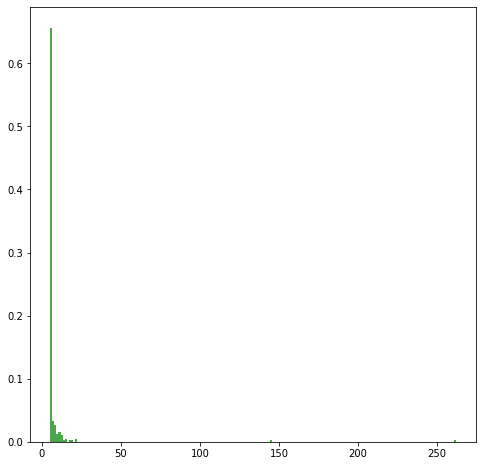

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
n, bins, patches = plt.hist(timings, 200, 
                            density = 1, 
                            color ='green',
                            alpha = 0.7)

#plt.hist(timings, bins=100)
plt.show()
